In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Yearly interest
r = 0.01
R0 = np.exp(r)

In [272]:
def sample_V(R1, years, sample_size, p, c, yearly_investment=1000):
    frac = lambda k: p*(1-c*(k-1)/30)
    q = np.array([frac(i) for i in range(30)])
    phi = q*(R1 - R0) + R0
    return pd.DataFrame(yearly_investment*phi.sort_index(axis=1,ascending=False).cumprod(axis=1).sum(axis=1))

def sample_V_rec(R1, years, sample_size, p, c, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            frac = p*(1-c*(k)/30)
            V = (yearly_investment + V)*frac*R1.iloc[i,k] + (1-frac)*(yearly_investment + V)*R0
        temp.append(V)
    return pd.DataFrame(temp)

def sample_V_TI(R1, years, sample_size, r_bar, yearly_investment=1000):
    G = np.array([yearly_investment*np.exp(r_bar*(j+1)) for j in range(years)]).cumsum()
    phi = G + (yearly_investment - G*np.exp(-r))*R1#(R0-R1)*G*np.exp(-r) + yearly_investment*np.exp(-r)*R1
    
    R1_aug = R1.shift(-1, axis=1)
    R1_aug[years-1] = 1

    return pd.DataFrame((phi * R1_aug.sort_index(axis=1, ascending=False).cumprod(axis=1).sort_index(axis=1)).sum(axis=1))

def sample_V_TI_rec(R1, years, sample_size, r_bar, yearly_investment=1000):
    temp = []
    for i in range(sample_size):
        V = 0
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            V = (V + yearly_investment - G*np.exp(-r))*R1.iloc[i,k] + G*np.exp(-r)*R0
        temp.append(V)

    return pd.DataFrame(temp)

def sample_V_lev(years, sample_size, r_bar, leverage=1, yearly_investment=1000):
    V_list = []
    for i in range(sample_size):
        Z = np.random.standard_normal(size=years)
        R1 = np.exp(my + sigma*Z)
        V = 0
        strat = True
        for k in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(k+1)])
            if strat:
                V_ = (V + yearly_investment - leverage*(V + yearly_investment - G*np.exp(-r)))*R0 + leverage*(V + yearly_investment - G*np.exp(-r))*R1[k]
            else:
                V_ = V + 1000
            V = V_
            
            if G>V:
                strat = False
            else:
                strat = True
                
        V_list.append(V)
    return pd.DataFrame(V_list)

def emp_dist(x, samples):
    ind = samples < x
    return (ind.sum()/samples.shape[0])[0]

def emp_quantile(p, samples):
    samples = samples.sort_values(by=0)
    #+1 since we want ceil
    ind = int(samples.shape[0]*(1-p) + 1)
    return samples.loc[ind][0]

In [273]:
sample_size = int(1e4)
years = 30
my, sigma = 0.03, 0.2

Z = pd.DataFrame(np.random.standard_normal(size=(sample_size,years)))
R1 = np.exp(my + sigma*Z)

<AxesSubplot:ylabel='Frequency'>

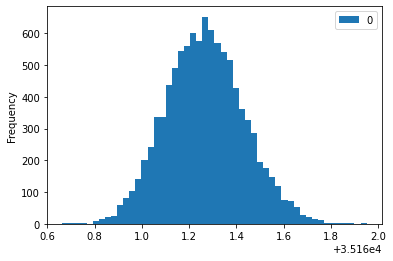

In [274]:
p, c = 1e-5, 5e-1

V_30 = sample_V(R1, years, sample_size,p, c, yearly_investment=1000)
V_30.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

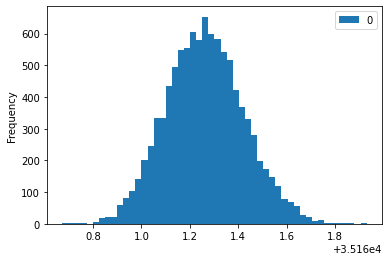

In [275]:
V_30_rec = sample_V_rec(R1, years, sample_size,p, c, yearly_investment=1000)
V_30_rec.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

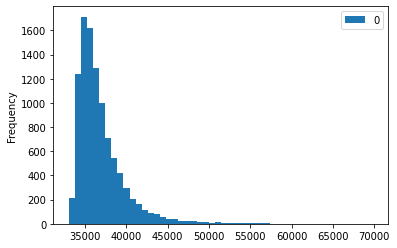

In [276]:
r_bar = 0.005

V_30_TI = sample_V_TI(R1, years, sample_size, r_bar)
V_30_TI.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

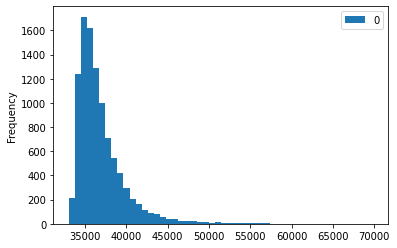

In [278]:
V_30_TI_rec = sample_V_TI_rec(R1, years, sample_size, r_bar)
V_30_TI_rec.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

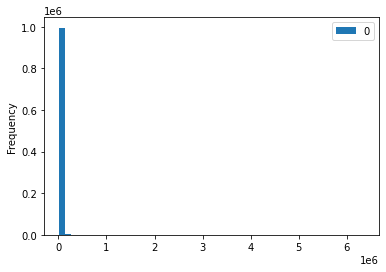

In [180]:
r_bar = 0.005
sample_lev = sample_V_lev(years, sample_size, r_bar, leverage=2)
sample_lev.plot.hist(bins=50)